In [1]:
!pwd

/panda/eedy/iono-notebook


In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import h5py
import numpy as np
import os
import datetime as dt
import numpy as np
import math
from scipy import interpolate
from mintpy.objects import ionex, timeseries
from mintpy.simulation import iono
from mintpy.utils import readfile, writefile
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
from mintpy import iono_tec
from mintpy.cli import diff, ifgram_inversion, modify_network, reference_point, reference_date
from mintpy.utils import utils as ut
from tqdm import trange
import h5py

from datetime import datetime
from netCDF4 import Dataset
from mintpy.utils import ptime, readfile, writefile


In [3]:
tframe_left = gpd.read_file("/home/eedy/data/aux/tframe_orbit/tframe_left_look.gpkg")
tframe_left.crs = "EPSG:4326"
# 初始化列表
ascending_frame_time_date = []
ascending_frame_time_utc_sec = []
ascending_NearLookAngle = []
ascending_FarLookAngle = []
ascending_lat1 = []
ascending_lon1 = []
ascending_lat2 = []
ascending_lon2 = []
ascending_lat3 = []
ascending_lon3 = []
ascending_lat4 = []
ascending_lon4 = []

descending_frame_time_date = []
descending_frame_time_utc_sec = []
descending_latitude = []
descending_longitude = []
descending_NearLookAngle = []
descending_FarLookAngle = []
descending_lat1 = []
descending_lon1 = []
descending_lat2 = []
descending_lon2 = []
descending_lat3 = []
descending_lon3 = []
descending_lat4 = []
descending_lon4 = []

# 遍历 track_frame
for index, row in tframe_left.iterrows():
    # 获取日期和时间
    startET = row['startET']
    endET = row['endET']
    tcenter = (startET + endET)/2.0
    import datetime
    frame_time_utc = datetime.datetime(2000,1,1)+datetime.timedelta(seconds=tcenter)
    frame_time_date = frame_time_utc.date()
    frame_time_utc_sec = frame_time_utc.hour * 60 + frame_time_utc.minute + frame_time_utc.second / 60

    # 获取入射角
    swathNearLookAngle = row['swathNearLookAngle']
    swathFarLookAngle = row['swathFarLookAngle']

    polygon = row['geometry']
    exterior_coords = polygon.geoms[0].exterior.coords
    # 提取四个角点
    corners = [exterior_coords[0], exterior_coords[len(exterior_coords) // 4],exterior_coords[len(exterior_coords) // 2], exterior_coords[3 * len(exterior_coords) // 4]]
    ## 1:右下  2:左下  3:左上  4:右上
    ## 1\4:FarLookAngle  2\3:NearLookAngle

    lat1 = corners[0][1]
    lon1 = corners[0][0]
    lat2 = corners[1][1]
    lon2 = corners[1][0]
    lat3 = corners[2][1]
    lon3 = corners[2][0]
    lat4 = corners[3][1]
    lon4 = corners[3][0]
    
    
    # 根据 passDirection 来决定是 ascending 还是 descending
    pass_direction = row['passDirection']
    
    if pass_direction == 'Ascending':
        ascending_frame_time_date.append(frame_time_date)
        ascending_frame_time_utc_sec.append(frame_time_utc_sec)
        ascending_NearLookAngle.append(swathNearLookAngle)
        ascending_FarLookAngle.append(swathFarLookAngle)
        ascending_lat1.append(lat1)
        ascending_lon1.append(lon1)
        ascending_lat2.append(lat2)
        ascending_lon2.append(lon2)
        ascending_lat3.append(lat3)
        ascending_lon3.append(lon3)
        ascending_lat4.append(lat4)
        ascending_lon4.append(lon4)
        
    elif pass_direction == 'Descending':
        descending_frame_time_date.append(frame_time_date)
        descending_frame_time_utc_sec.append(frame_time_utc_sec)
        descending_NearLookAngle.append(swathNearLookAngle)
        descending_FarLookAngle.append(swathFarLookAngle)
        descending_lat1.append(lat1)
        descending_lon1.append(lon1)
        descending_lat2.append(lat2)
        descending_lon2.append(lon2)
        descending_lat3.append(lat3)
        descending_lon3.append(lon3)
        descending_lat4.append(lat4)
        descending_lon4.append(lon4)
    else:
        # 处理其他情况，如果有的话
        pass


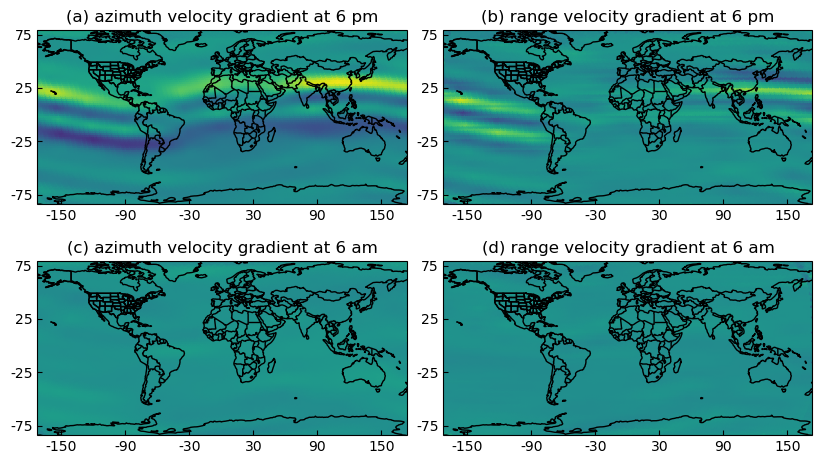

In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec

# 定义一个函数来处理数据
def process_data(year_range, data_path_prefix):
    r_iono_all_1 = []
    r_iono_all_2 = []
    r_iono_all_3 = []
    r_iono_all_4 = []

    for year in year_range:
        # 打开.h5文件进行读取
        with h5py.File(f'{data_path_prefix}_{year}.h5', 'r') as h5f:
            # 读取数据集
            r_iono_1 = h5f['r_iono_1'][:]
            r_iono_2 = h5f['r_iono_2'][:]
            r_iono_3 = h5f['r_iono_3'][:]
            r_iono_4 = h5f['r_iono_4'][:]

        r_iono_means_1 = []
        r_iono_means_2 = []
        r_iono_means_3 = []
        r_iono_means_4 = []

        # 检查子列表长度是否相同
        lengths = [len(sublist) for sublist in r_iono_1]
        for index in range(len(r_iono_1[0])):
            # 收集每个子列表对应索引的元素
            values = [sublist[index] for sublist in r_iono_1]
            # 计算均值，忽略 np.nan
            mean_value = np.nanmean(values)
            r_iono_means_1.append(mean_value)

        # 检查子列表长度是否相同
        lengths = [len(sublist) for sublist in r_iono_2]
        for index in range(len(r_iono_1[0])):
            # 收集每个子列表对应索引的元素
            values = [sublist[index] for sublist in r_iono_2]
            # 计算均值，忽略 np.nan
            mean_value = np.nanmean(values)
            r_iono_means_2.append(mean_value)

        # 检查子列表长度是否相同
        lengths = [len(sublist) for sublist in r_iono_3]
        for index in range(len(r_iono_1[0])):
            # 收集每个子列表对应索引的元素
            values = [sublist[index] for sublist in r_iono_3]
            # 计算均值，忽略 np.nan
            mean_value = np.nanmean(values)
            r_iono_means_3.append(mean_value)

        # 检查子列表长度是否相同
        lengths = [len(sublist) for sublist in r_iono_4]
        for index in range(len(r_iono_1[0])):
            # 收集每个子列表对应索引的元素
            values = [sublist[index] for sublist in r_iono_4]
            # 计算均值，忽略 np.nan
            mean_value = np.nanmean(values)
            r_iono_means_4.append(mean_value)

        r_iono_all_1.append(r_iono_means_1)
        r_iono_all_2.append(r_iono_means_2)
        r_iono_all_3.append(r_iono_means_3)
        r_iono_all_4.append(r_iono_means_4)

    # 计算每年变化的均值
    r_iono_all_1_array = np.array(r_iono_all_1)
    vel_r_iono_all_1_list = []
    for i in range(1, r_iono_all_1_array.shape[0]):
        vel_r_iono_all_1 = r_iono_all_1_array[i, :] - r_iono_all_1_array[i - 1, :]
        vel_r_iono_all_1_list.append(vel_r_iono_all_1)
    vel_r_iono_all_1_array = np.array(vel_r_iono_all_1_list)
    avg_r_iono_all_1 = np.mean(vel_r_iono_all_1_array, axis=0)

    r_iono_all_2_array = np.array(r_iono_all_2)
    vel_r_iono_all_2_list = []
    for i in range(1, r_iono_all_2_array.shape[0]):
        vel_r_iono_all_2 = r_iono_all_2_array[i, :] - r_iono_all_2_array[i - 1, :]
        vel_r_iono_all_2_list.append(vel_r_iono_all_2)
    vel_r_iono_all_2_array = np.array(vel_r_iono_all_2_list)
    avg_r_iono_all_2 = np.mean(vel_r_iono_all_2_array, axis=0)

    r_iono_all_3_array = np.array(r_iono_all_3)
    vel_r_iono_all_3_list = []
    for i in range(1, r_iono_all_3_array.shape[0]):
        vel_r_iono_all_3 = r_iono_all_3_array[i, :] - r_iono_all_3_array[i - 1, :]
        vel_r_iono_all_3_list.append(vel_r_iono_all_3)
    vel_r_iono_all_3_array = np.array(vel_r_iono_all_3_list)
    avg_r_iono_all_3 = np.mean(vel_r_iono_all_3_array, axis=0)

    r_iono_all_4_array = np.array(r_iono_all_4)
    vel_r_iono_all_4_list = []
    for i in range(1, r_iono_all_4_array.shape[0]):
        vel_r_iono_all_4 = r_iono_all_4_array[i, :] - r_iono_all_4_array[i - 1, :]
        vel_r_iono_all_4_list.append(vel_r_iono_all_4)
    vel_r_iono_all_4_array = np.array(vel_r_iono_all_4_list)
    avg_r_iono_all_4 = np.mean(vel_r_iono_all_4_array, axis=0)

    return avg_r_iono_all_1, avg_r_iono_all_2, avg_r_iono_all_3, avg_r_iono_all_4

# 定义一个函数来计算坡度和坡向
def calculate_slope(lon1, lat1, lon2, lat2, lon3, lat3, lon4, lat4, avg1, avg2, avg3, avg4):
    n = len(lon1)
    dx = []
    dy = []
    center_lon = []
    center_lat = []

    for i in range(n):
        # 获取四个端点的经纬度和值
        lon1_i, lat1_i, z1 = lon1[i], lat1[i], avg1[i]
        lon2_i, lat2_i, z2 = lon2[i], lat2[i], avg2[i]
        lon3_i, lat3_i, z3 = lon3[i], lat3[i], avg3[i]
        lon4_i, lat4_i, z4 = lon4[i], lat4[i], avg4[i]

        # 计算中心点的经纬度
        center_loni = (lon1_i + lon2_i + lon3_i + lon4_i) / 4
        center_lati = (lat1_i + lat2_i + lat3_i + lat4_i) / 4

        # 计算坡度和坡向
        dz_dx = ((z2 - z1) + (z4 - z3)) / 2
        dz_dy = ((z3 - z2) + (z4 - z1)) / 2

        center_lon.append(center_loni)
        center_lat.append(center_lati)
        dx.append(dz_dx * 1000 / 2.5)
        dy.append(dz_dy * 1000 / 2.5)

    return dx, dy

# 处理上升数据
year_range = range(2014, 2020)
data_path_prefix_asc = 'data/new_global_a/asc_iono'
avg_r_iono_all_1_asc, avg_r_iono_all_2_asc, avg_r_iono_all_3_asc, avg_r_iono_all_4_asc = process_data(year_range, data_path_prefix_asc)
dx_asc, dy_asc = calculate_slope(ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, avg_r_iono_all_1_asc, avg_r_iono_all_2_asc, avg_r_iono_all_3_asc, avg_r_iono_all_4_asc)

# 处理下降数据
data_path_prefix_des = 'data/new_global_d/des_iono'
avg_r_iono_all_1_des, avg_r_iono_all_2_des, avg_r_iono_all_3_des, avg_r_iono_all_4_des = process_data(year_range, data_path_prefix_des)
dx_des, dy_des = calculate_slope(descending_lon1, descending_lat1, descending_lon2, descending_lat2, descending_lon3, descending_lat3, descending_lon4, descending_lat4, avg_r_iono_all_1_des, avg_r_iono_all_2_des, avg_r_iono_all_3_des, avg_r_iono_all_4_des)

# 创建一个包含 2 行 2 列的网格布局（去掉颜色条行）
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

# 定义一个函数来绘制子图
def plot_subplot(ax, lon1, lat1, lon2, lat2, lon3, lat3, lon4, lat4, values, vmin, vmax, title):
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    sc1 = ax.scatter(lon1, lat1, c=values, cmap='viridis', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    sc2 = ax.scatter(lon2, lat2, c=values, cmap='viridis', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    sc3 = ax.scatter(lon3, lat3, c=values, cmap='viridis', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    sc4 = ax.scatter(lon4, lat4, c=values, cmap='viridis', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)

    ax.set_extent([-172.5, 173.5, -84, 79], crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', direction='in')

    xticks = np.arange(-150, 151, 60)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticks)

    yticks = np.arange(-75, 76, 50)
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_yticklabels(yticks)

    ax.set_title(title)

# 绘制上升方位坡度图
ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
plot_subplot(ax1, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, dy_asc, -130, 130, '(a) azimuth velocity gradient at 6 pm')

# 绘制上升距离坡度图
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
plot_subplot(ax2, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, dx_asc, -20, 20, '(b) range velocity gradient at 6 pm')

# 绘制下降方位坡度图
ax3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
plot_subplot(ax3, descending_lon1, descending_lat1, descending_lon2, descending_lat2, descending_lon3, descending_lat3, descending_lon4, descending_lat4, dy_des, -130, 130, '(c) azimuth velocity gradient at 6 am')

# 绘制下降距离坡度图
ax4 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())
plot_subplot(ax4, descending_lon1, descending_lat1, descending_lon2, descending_lat2, descending_lon3, descending_lat3, descending_lon4, descending_lat4, dx_des, -20, 20, '(d) range velocity gradient at 6 am')

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.1, hspace=-0.4)

# 保存图像
plt.savefig('pic/global_iono.png', bbox_inches='tight', dpi=600, transparent=True)

# 显示图像
plt.show()

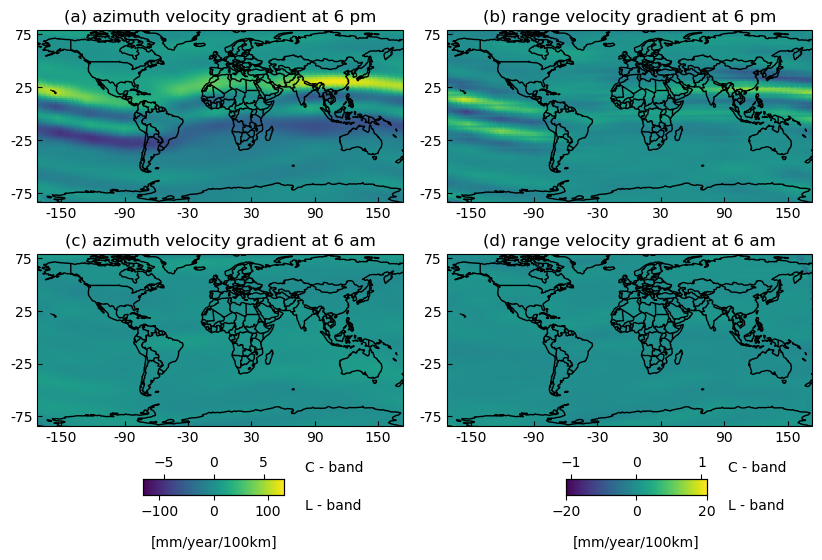

In [21]:
# 创建一个包含 2 行 2 列的网格布局（去掉颜色条行）
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)


# 定义一个函数来绘制子图
def plot_subplot(ax, lon1, lat1, lon2, lat2, lon3, lat3, lon4, lat4, values, vmin, vmax, title):
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS)

    sc = ax.scatter(lon1, lat1, c=values, cmap='viridis', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon2, lat2, c=values, cmap='viridis', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon3, lat3, c=values, cmap='viridis', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon4, lat4, c=values, cmap='viridis', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)

    ax.set_extent([-172.5, 173.5, -84, 79], crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', direction='in')

    xticks = np.arange(-150, 151, 60)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticks)

    yticks = np.arange(-75, 76, 50)
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_yticklabels(yticks)

    ax.set_title(title)
    return sc


# 绘制上升方位坡度图
ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
plot_subplot(ax1, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, dy_asc, -130, 130, '(a) azimuth velocity gradient at 6 pm')

# 绘制上升距离坡度图
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
plot_subplot(ax2, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, dx_asc, -20, 20, '(b) range velocity gradient at 6 pm')

# 绘制下降方位坡度图
ax3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
sc3 = plot_subplot(ax3, descending_lon1, descending_lat1, descending_lon2, descending_lat2, descending_lon3, descending_lat3, descending_lon4, descending_lat4, dy_des, -130, 130, '(c) azimuth velocity gradient at 6 am')

# 绘制下降距离坡度图
ax4 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())
sc4 = plot_subplot(ax4, descending_lon1, descending_lat1, descending_lon2, descending_lat2, descending_lon3, descending_lat3, descending_lon4, descending_lat4, dx_des, -20, 20, '(d) range velocity gradient at 6 am')

L = 1.257
C = 5.405
radio = L ** 2 / C ** 2

# 为第三个子图添加 colorbar
cax3 = fig.add_axes([ax3.get_position().x0 + 0.3 * ax3.get_position().width,
                     ax3.get_position().y0 - 0.02,  # 往上挪一些
                     0.4 * ax3.get_position().width,
                     0.02])
norm3 = plt.Normalize(vmin=-130, vmax=130)
sm3 = plt.cm.ScalarMappable(cmap='viridis', norm=norm3)
sm3.set_array(sc3.get_array())
cb3 = fig.colorbar(sm3, cax=cax3, orientation='horizontal')
sm3.set_clim(vmin=-130, vmax=130)
ax3_2 = cax3.twiny()
ax3_2.set_xlim(-130 * radio, 130 * radio)
cax3.text(1.15, -0.7, 'L - band', transform=cax3.transAxes, va='center')  # 文字往右挪一些
ax3_2.text(1.15, 1.7, 'C - band', transform=ax3_2.transAxes, va='center')  # 文字往右挪一些
fig.text(ax3.get_position().x0 + 0.5 * ax3.get_position().width, ax3.get_position().y0 - 0.08, '[mm/year/100km]',
         ha='center', va='center', fontsize=10)

# 为第四个子图添加 colorbar
cax4 = fig.add_axes([ax4.get_position().x0 + 0.3 * ax4.get_position().width,
                     ax4.get_position().y0 - 0.02,  # 往上挪一些
                     0.4 * ax4.get_position().width,
                     0.02])
norm4 = plt.Normalize(vmin=-20, vmax=20)
sm4 = plt.cm.ScalarMappable(cmap='viridis', norm=norm4)
sm4.set_array(sc4.get_array())
cb4 = fig.colorbar(sm4, cax=cax4, orientation='horizontal')
sm4.set_clim(vmin=-20, vmax=20)
ax4_2 = cax4.twiny()
ax4_2.set_xlim(-20 * radio, 20 * radio)
cax4.text(1.15, -0.7, 'L - band', transform=cax4.transAxes, va='center')  # 文字往右挪一些
ax4_2.text(1.15, 1.7, 'C - band', transform=ax4_2.transAxes, va='center')  # 文字往右挪一些
fig.text(ax4.get_position().x0 + 0.5 * ax4.get_position().width, ax4.get_position().y0 - 0.08, '[mm/year/100km]',
         ha='center', va='center', fontsize=10)

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.12, hspace=-0.43)
# 保存图像
plt.savefig('pdf/global_iono.pdf', bbox_inches='tight', dpi=600, transparent=True)
# 显示图像
plt.show()